In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyace import *
from pyace.linearacefit import LinearACEFit, LinearACEDataset
from pyace.generalfit import GeneralACEFit

In [3]:
df0=pd.read_pickle("./Datasets/Cu_df2_1k.pkl.gzip", compression="gzip")

In [4]:
df0.shape

(1000, 5)

In [5]:
df0

,name,ase_atoms,energy_corrected,forces,energy_corrected_per_atom
0,A1:FHI-aims/PBE/tight:elastic:s_e_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699843,"[[0.0, 0.0, 0.0]]",-3.699843
1,A1:FHI-aims/PBE/tight:murnaghan:strain_1_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699841,"[[0.0, 0.0, 0.0]]",-3.699841
2,A1:FHI-aims/PBE/tight:phonon:supercell_phonon_0,"(Atom('Cu', [4.3368086899420173e-19, 0.0070709...",-236.789603,"[[-1.13852957740976e-06, -0.0464638907314277, ...",-3.699838
3,A1:FHI-aims/PBE/tight:murnaghan:strain_1_02,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697932,"[[0.0, 0.0, 0.0]]",-3.697932
4,A1:FHI-aims/PBE/tight:qha:phonopy_strain_1_02:...,"(Atom('Cu', [0.0, 0.007070999999999999, 0.0070...",-236.667372,"[[-1.7950713845026e-06, -0.0426786586259085, -...",-3.697928
...,...,...,...,...,...
995,Zr4Al3,"(Atom('Cu', [1.397, 0.806558, 0.0], index=0), ...",-18.922813,"[[-6.18422096975777e-08, 3.90650715661433e-08,...",-2.703259
996,fcc_100surf_X110_Y-110_Z001_4at_d0.95,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",-10.811770,"[[-4.30878346990838e-07, -7.31495829958533e-08...",-2.702942
997,ran2.7197,"(Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...",-5.405739,"[[-0.233777024216308, -0.488775610406501, 0.45...",-2.702869
998,A15.shakesmallsuper2.14,"(Atom('Cu', [19.532944999999994, -0.449866, 19...",-172.952480,"[[0.872967501214253, 0.798687481685555, 0.8365...",-2.702382


<dl>
<dt>Columns have the following meaning:</dt>
<ul>
<li><strong>ase_atoms:</strong> is the instance of the ASE Atoms class. This is the main form of storing structural information that pacemaker relies on. It must contain information about atomic positions, corresponding atom types, pbc and lattice vectors.</li>
<li><strong>energy_corrected:</strong> total energy of the corresponding ase_atoms structure (in eV) minus a reference energy.</li>
<li><strong>forces:</strong> corresponding atomic forces in the form of 2D array with dimensions [NumberOfAtoms, 3] (in eV/A).</li>
<li><strong>energy_corrected_per_atom:</strong> energy per atom minus a reference energy.</li>
</ul>
</dl>

In [6]:
df0["ase_atoms"]

0                 (Atom('Cu', [0.0, 0.0, 0.0], index=0))
1                 (Atom('Cu', [0.0, 0.0, 0.0], index=0))
2      (Atom('Cu', [4.3368086899420173e-19, 0.0070709...
3                 (Atom('Cu', [0.0, 0.0, 0.0], index=0))
4      (Atom('Cu', [0.0, 0.007070999999999999, 0.0070...
                             ...                        
995    (Atom('Cu', [1.397, 0.806558, 0.0], index=0), ...
996    (Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...
997    (Atom('Cu', [0.0, 0.0, 0.0], index=0), Atom('C...
998    (Atom('Cu', [19.532944999999994, -0.449866, 19...
999    (Atom('Cu', [11.302489999999999, 10.996904, 10...
Name: ase_atoms, Length: 1000, dtype: object

In [7]:
df0["ase_atoms"].map(len).sum()

11309

In [48]:
# split 95% train, 5% test
df_train = df0.sample(frac=0.95, random_state=42)
df_test = df0.loc[(i for i in df0.index if i not in df_train.index)]

In [28]:
len(df_train), len(df_test)

(950, 50)

In [29]:
# Create empty bbasis configuration
bconf = create_multispecies_basis_config(potential_config = {
  "deltaSplineBins": 0.001,
  "elements": ['Cu'],

  "embeddings": {
    "ALL": {
      "npot": 'FinnisSinclairShiftedScaled',
      "fs_parameters": [ 1, 1],
      "ndensity": 1,
    },
  },

  "bonds": {
    "ALL": {
      "radbase": "SBessel",
      "radparameters": [ 5.25 ],
      "rcut": 6,
      "dcut": 0.01,
    }
  },

  "functions": {
    # "number_of_functions_per_element": 1000,
    "ALL": {
        "nradmax_by_orders": [ 8, 8, 4, 3,2],
        "lmax_by_orders"   : [ 0, 4, 3, 2,1] }
  }
})

In [30]:
bconf.total_number_of_functions

822

# Prepare linear ACE dataset

In [31]:
train_ds = LinearACEDataset(bconf, df_train)

In [32]:
test_ds = LinearACEDataset(bconf, df_test)

Construct design matrix for train and test, by default - in parallel with 4 workers/processes. 
Set verbose=False to suppress output

In [33]:
train_ds.construct_design_matrix(verbose=True)
test_ds.construct_design_matrix(verbose=True)

Create linear ACE fit class, provide train dataset

In [34]:
linear_fit = LinearACEFit(train_dataset=train_ds)

Call fit method, by default it use Ridge from sklearn

In [35]:
linear_fit.fit()

Ridge(alpha=1e-05, copy_X=False, fit_intercept=False, random_state=42)

Compute error metrics on train and test (in eV/atom and eV/A)

In [36]:
linear_fit.compute_errors(train_ds)

{'epa_mae': 3.3209504062294197,
 'epa_rmse': 3.3337136659560076,
 'f_comp_mae': 0.25344754386210955,
 'f_comp_rmse': 0.7537146812385023}

In [37]:
linear_fit.compute_errors(test_ds)

{'epa_mae': 3.311518097661182,
 'epa_rmse': 3.3245661379724116,
 'f_comp_mae': 0.20128637475842273,
 'f_comp_rmse': 0.9995089916491627}

## Trained basis export and usage

Get fitted basis and use in PyACECalculator

In [38]:
basis = linear_fit.get_bbasis()

In [39]:
calc = PyACECalculator(basis)

In [47]:
e_pred,f_pred = linear_fit.predict(test_ds, reshape_forces=True)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [46]:
# take first  ase_atoms
at = df_test.iloc[0]["ase_atoms"].copy()
at

Atoms(symbols='Cu', pbc=True, cell=[[0.0, 1.815377, 1.815377], [1.815377, 0.0, 1.815377], [1.815377, 1.815377, 0.0]])

In [42]:
at.set_calculator(calc)

In [43]:
at.get_potential_energy()

G:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\venv\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


0.0

Compare PyACECalculator predictions with LinearFit predictions

In [44]:
np.allclose(at.get_potential_energy()/len(at),e_pred[0])

True

In [33]:
np.allclose(at.get_forces(),f_pred[:len(at)])

True

# Manual design matrix manipulation and fit

In [36]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

Get design matrix explicitly

In [37]:
train_dm = train_ds.get_design_matrix()

Size of design matrix is  n_structures + 3 * n_atoms  by n_func.

First n_structures row correspond to summed up B-basis projections for each structure, divided by size of corresponding structure

Remaining 3 * n_atoms rows are corresponding x-,y- and z-force components for each atom

In [38]:
train_dm.shape

(33590, 822)

Get target vector explicitly

In [39]:
train_y = train_ds.get_target_vector()

Size of design matrix is  n_structures + 3 * n_atoms  by n_func

First n_structures row correspond to energy-per-atom each structure

Remaining 3 * n_atoms rows are corresponding x-,y- and z-force components for each atoms

In [40]:
train_y.shape

(33590,)

In [41]:
train_ds.total_number_of_structures + 3* train_ds.total_number_of_atoms

33590

In [42]:
B_funcs = train_dm[:train_ds.total_number_of_structures]

In [43]:
B_grad_funcs = train_dm[train_ds.total_number_of_structures:]

## Visualization of design matrix features (B-func and B-func grad)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_15756\226716087.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


Text(0, 0.5, 'B-func spread (max-min)')

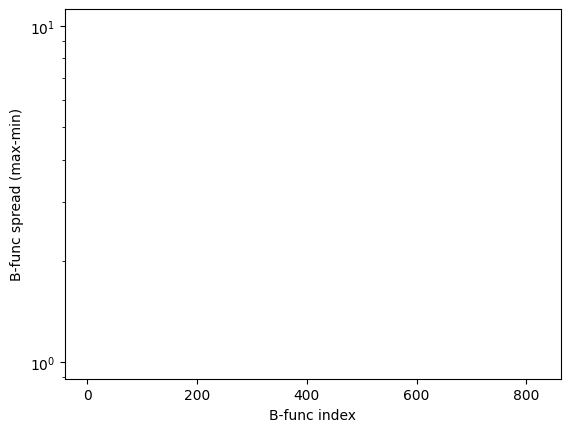

In [47]:
B_funcs_spread = B_funcs.max(axis=0)-B_funcs.min(axis=0)

plt.plot(B_funcs_spread)
plt.yscale('log')
plt.xlabel("B-func index")
plt.ylabel("B-func spread (max-min)")

C:\Users\Aaron\AppData\Local\Temp\ipykernel_15756\712541126.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log');


Text(0, 0.5, 'B-grad-func spread (max-min)')

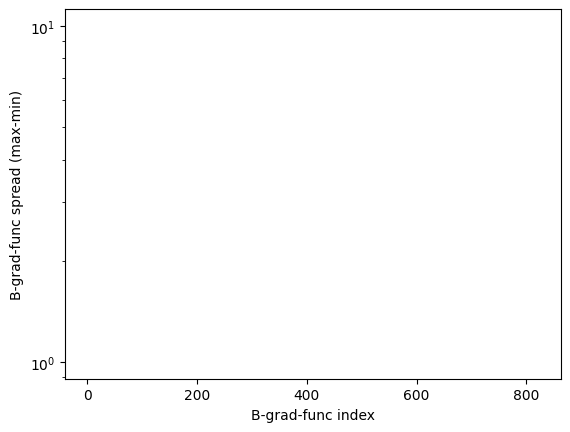

In [46]:
B_grad_funcs_spread = B_grad_funcs.max(axis=0)-B_grad_funcs.min(axis=0)

plt.plot(B_grad_funcs_spread)
plt.yscale('log')
plt.xlabel("B-grad-func index")
plt.ylabel("B-grad-func spread (max-min)")

## Create linear model manually

Create Ridge model

In [48]:
model = Ridge(alpha=1e-10, fit_intercept=False, copy_X=False, random_state=42, solver="auto")

In [49]:
model.fit(train_dm, train_y)

Ridge(alpha=1e-10, copy_X=False, fit_intercept=False, random_state=42)

get model predictions on train design matrix

In [50]:
train_pred = model.predict(train_dm)

Extract energy-per-atom (epa) and forces from predicted vector

In [51]:
epa_pred = train_ds.get_energies_per_atom(train_pred)

In [52]:
f_pred = train_ds.get_forces(train_pred)

Compute error metrics for *train* dataset, using predicted EPA and forces.
Reference values are stored in dataset and used automatically, unless provided otherwise

In [53]:
train_ds.compute_errors(epa_pred, f_pred)

{'epa_mae': 3.3169604922805593,
 'epa_rmse': 3.3298844179388123,
 'f_comp_mae': 0.24984014995185277,
 'f_comp_rmse': 0.7655393790811638}

## Using PCA for dimensionality reduction

In [55]:
pca = PCA()
train_dm_pca = pca.fit_transform(train_dm)

G:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\venv\lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: divide by zero encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
G:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\venv\lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [56]:
model = Ridge(alpha=1e-10, fit_intercept=False, copy_X=False, random_state=42, solver="auto")

In [57]:
model.fit(train_dm_pca, train_y)

Ridge(alpha=1e-10, copy_X=False, fit_intercept=False, random_state=42)

In [58]:
train_pred = model.predict(train_dm_pca)

In [59]:
epa_pred = train_ds.get_energies_per_atom(train_pred)

In [60]:
f_pred = train_ds.get_forces(train_pred)

In [61]:
train_ds.compute_errors(epa_pred, f_pred)

{'epa_mae': 3.3169604922805593,
 'epa_rmse': 3.3298844179388123,
 'f_comp_mae': 0.24984014995185277,
 'f_comp_rmse': 0.7655393790811638}

## Fit of energies-only

In [65]:
B_funcs = train_dm[:train_ds.total_number_of_structures]

In [66]:
epa_ref = train_y[:train_ds.total_number_of_structures]

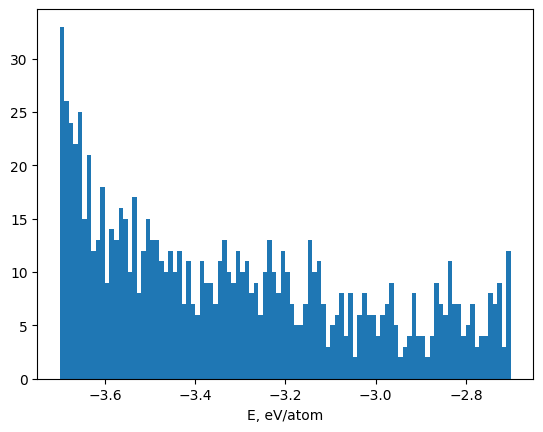

In [67]:
plt.hist(epa_ref,bins=100)
plt.xlabel("E, eV/atom");

In [68]:
model = Ridge(alpha=1e-10, fit_intercept=False, copy_X=False, random_state=42, solver="auto")

In [69]:
model.fit(B_funcs,epa_ref)

Ridge(alpha=1e-10, copy_X=False, fit_intercept=False, random_state=42)

In [70]:
epa_pred = model.predict(B_funcs)

In [71]:
# E-RMSE, meV/at
np.sqrt(np.mean((epa_pred-epa_ref)**2))*1e3 

3329.8844179388125

### Energies-only with PCA

In [72]:
B_funcs_pca = PCA().fit_transform(B_funcs)

G:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\venv\lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: divide by zero encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
G:\Uni\Master Physik\Masterarbeit\Repo\long-range-ml-potential\venv\lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [73]:
B_funcs_pca_spread=B_funcs_pca.max(axis=0)-B_funcs_pca.min(axis=0)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_15756\4293140399.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log');


Text(0, 0.5, 'B-func PCA spread (max-min)')

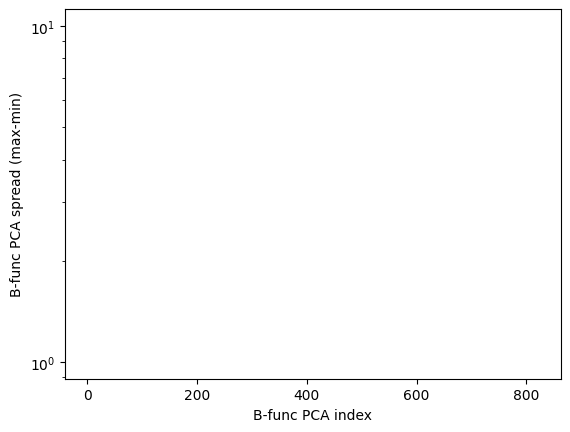

In [74]:
plt.plot(B_funcs_pca_spread)
plt.yscale('log')
plt.xlabel("B-func PCA index")
plt.ylabel("B-func PCA spread (max-min)")

In [75]:
model.fit(B_funcs_pca,epa_ref)

Ridge(alpha=1e-10, copy_X=False, fit_intercept=False, random_state=42)

In [76]:
epa_pred_pca = model.predict(B_funcs_pca)

In [77]:
# E-RMSE, meV/at
np.sqrt(np.mean((epa_pred_pca-epa_ref)**2))*1e3

3329.8844179388125